# Offline Phase: PBDW offline - computing the inf-sup constant

This notebook implements the offline phase of the following algorithm:

- Parameterised-Background Data-Weak (PBDW) formulation

In particular, the *inf-sup* constant $\beta_{N,M}$ is computed for the different point spread of the sensors and their Riesz representation, either in $L^2$ or in $H^1$.

In [1]:
import numpy as np
import os
from IPython.display import clear_output
import pickle

import gmsh
from mpi4py import MPI
from dolfinx.io.gmshio import model_to_mesh
from dolfinx.fem import FunctionSpace

from pyforce.tools.write_read import ImportH5, StoreFunctionsList as store
from pyforce.tools.functions_list import FunctionsList
from pyforce.offline.pbdw import PBDW

import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import cm

path_off ='./Offline_results/'

The geometry is imported from "ANL11A2_octave.geo", generated with GMSH. Then, the mesh is created with the gmsh module.

In [2]:
gdim = 2

model_rank = 0
mesh_comm = MPI.COMM_WORLD

# Initialize the gmsh module
gmsh.initialize()

# Load the .geo file
gmsh.merge('ANL11A2_octave.geo')
gmsh.model.geo.synchronize()

# Set algorithm (adaptive = 1, Frontal-Delaunay = 6)
gmsh.option.setNumber("Mesh.Algorithm", 6)

gmsh.model.mesh.generate(gdim)
gmsh.model.mesh.optimize("Netgen")

# Domain
domain, ct, ft = model_to_mesh(gmsh.model, comm = mesh_comm, rank = model_rank, gdim = gdim )
gmsh.finalize()

fuel1_marker    = 1
fuel2_marker    = 2
fuel_rod_marker = 3
refl_marker     = 4

void_marker     = 10
sym_marker      = 20

tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)

clear_output()

## Importing basis function and sensors

The functional space and the names of the fields are loaded.

In [3]:
# Defining the functional space
V = FunctionSpace(domain, ("Lagrange", 1))

# Define the variables to load
var_names = [
             'phi_1',
             'phi_2'
             ]

tex_var_names = [
                 r'\phi_1',
                 r'\phi_2'
                 ]

Let us import the POD modes

In [4]:
bf = dict()

for field_i in range(len(var_names)):
    
    bf[var_names[field_i]] = ImportH5(V, path_off+'/BasisFunctions/basisPOD_'+var_names[field_i], 'POD_'+var_names[field_i])[0]

Let us import the basis sensors for different point spreads.

In [5]:
s = [0.1, 1., 2.5]

is_H1 = [False, True]
fun_space_label = ['L2', 'H1']

bs = dict()

for field in var_names:
    bs[field] = dict()
    for s_jj in s:
        bs[field]['s = {:.2f}'.format(s_jj)] = dict()
        for space in fun_space_label:
             bs[field]['s = {:.2f}'.format(s_jj)][space] = ImportH5(V, 
                                                                    path_off+'/BasisSensors/sensorsSGREEDYPOD_' + field+'_s_{:.2e}_'.format(s_jj)+space,
                                                                    'SGREEDYPOD_' +field+'_s_{:.2e}'.format(s_jj))[0]

## Compute the *inf-sup* constant
Given the background space $Z_N = \text{span}\{\zeta_1, \zeta_2, \dots, \zeta_N\}$ and the update space $\mathcal{U}_M=\text{span}\{g_1, g_2, \dots, g_M\}$, the following matrices can be defined
\begin{equation*}
A_{mm'} = \left(g_m, g_{m'}\right)_{\mathcal{U}}\qquad
K_{mn} = \left(g_m, \zeta_{n}\right)_{\mathcal{U}} = v_m(\zeta_n)\qquad
B_{nn'} = \left(\zeta_n, \zeta_{n'}\right)_{\mathcal{U}}
\end{equation*}
The *inf-sup* constant $\beta_{N,M}$ is the square-root of the minimum eigenvalue of the following problem
\begin{equation*}
K^TA^{-1}K \mathbf{w}_j = \lambda_j B\mathbf{w}_j
\end{equation*}
that is $\beta_{N,M} = \sqrt{\min\limits_{j=1,\dots, N} \lambda_j}$.

Let us fix the dimension of the reduced space to $N=10$.

In [6]:
Nmax = 10
Mmax = 30

inf_sup_constants = dict()

for field in var_names:
    inf_sup_constants[field] = dict()
    for s_jj in s:
        inf_sup_constants[field]['s = {:.2f}'.format(s_jj)] = dict()
        for kk, space in enumerate(fun_space_label):
            
            print('Compute Inf-Sup for '+field+' with s={:.2f}'.format(s_jj)+' and Riesz representation in '+space)
            
            pbdw = PBDW(bf[field], bs[field]['s = {:.2f}'.format(s_jj)][space], is_H1[kk])
            inf_sup_constants[field]['s = {:.2f}'.format(s_jj)][space] = pbdw.compute_infsup(Nmax, Mmax)
            
            del pbdw

Compute Inf-Sup for phi_1 with s=0.10 and Riesz representation in L2
Compute Inf-Sup for phi_1 with s=0.10 and Riesz representation in H1
Compute Inf-Sup for phi_1 with s=1.00 and Riesz representation in L2
Compute Inf-Sup for phi_1 with s=1.00 and Riesz representation in H1
Compute Inf-Sup for phi_1 with s=2.50 and Riesz representation in L2
Compute Inf-Sup for phi_1 with s=2.50 and Riesz representation in H1
Compute Inf-Sup for phi_2 with s=0.10 and Riesz representation in L2
Compute Inf-Sup for phi_2 with s=0.10 and Riesz representation in H1
Compute Inf-Sup for phi_2 with s=1.00 and Riesz representation in L2
Compute Inf-Sup for phi_2 with s=1.00 and Riesz representation in H1
Compute Inf-Sup for phi_2 with s=2.50 and Riesz representation in L2
Compute Inf-Sup for phi_2 with s=2.50 and Riesz representation in H1


Let us plot the constant for the different configurations.

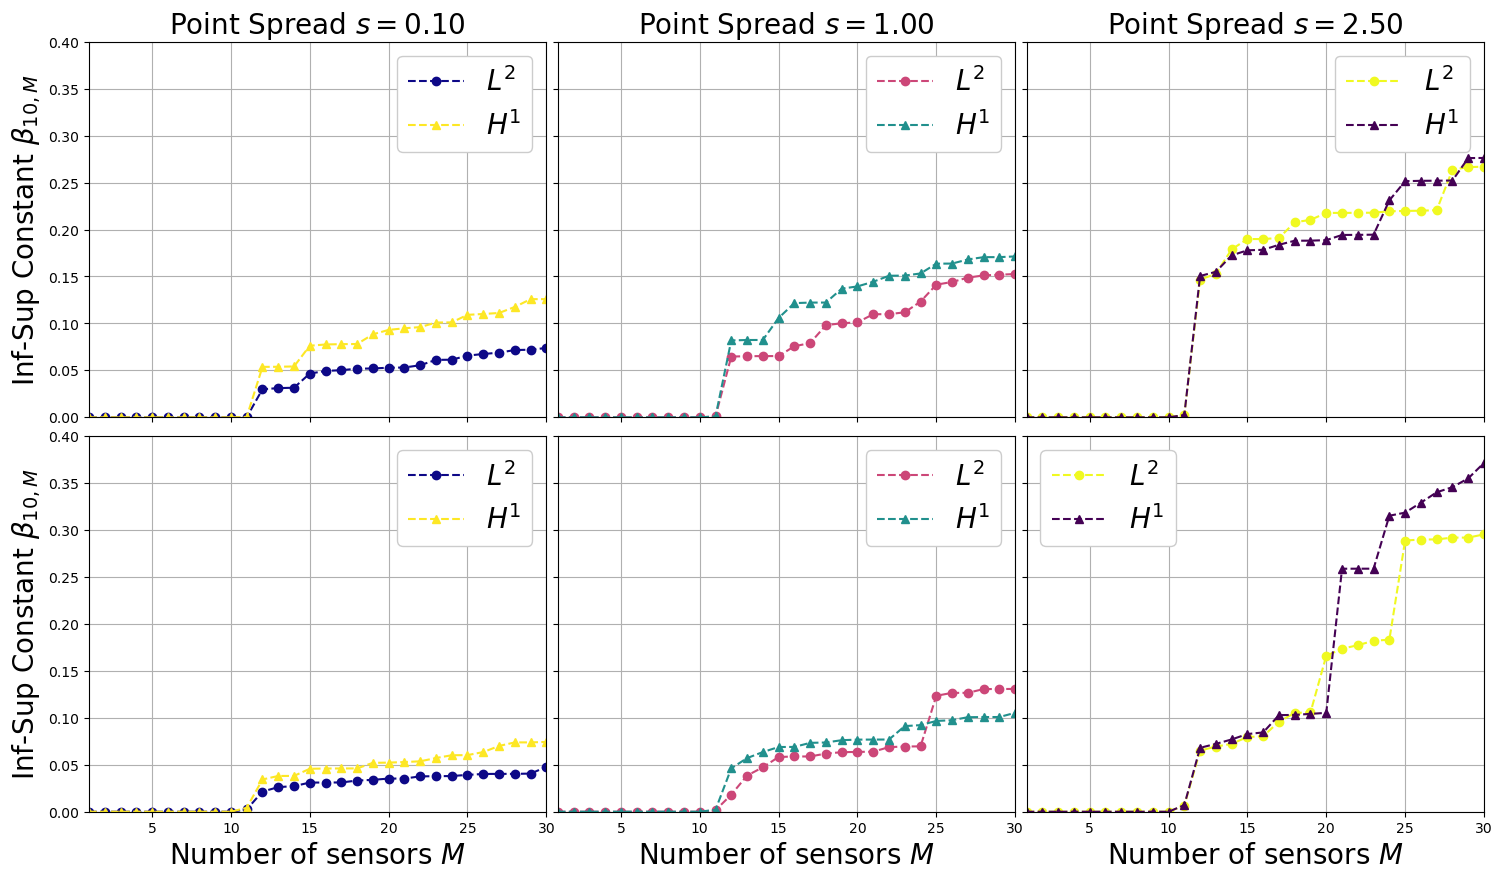

In [23]:
fig, axs = plt.subplots(nrows = len(var_names), ncols = len(s), sharey=True, sharex=True, figsize = (6 * len(s), 5 * len(var_names)))

Mplot = np.arange(1, Mmax + 1, 1)
colors_l2 = cm.plasma(np.linspace(0,1,len(s)))
colors_h1 = cm.viridis_r(np.linspace(0,1,len(s)))

for field_i, field in enumerate(var_names):
    for jj, s_jj in enumerate(s):
        axs[field_i, jj].plot(Mplot, inf_sup_constants[field]['s = {:.2f}'.format(s_jj)]['L2'], 
                              '--o', c=colors_l2[jj], label=r'$L^2$')
        axs[field_i, jj].plot(Mplot, inf_sup_constants[field]['s = {:.2f}'.format(s_jj)]['H1'], 
                              '--^', c=colors_h1[jj], label=r'$H^1$')
        
        axs[field_i, jj].set_ylim(0, 0.4)
        axs[field_i, jj].set_xlim(1, Mmax)
        axs[field_i, jj].grid()
        axs[field_i, jj].legend(framealpha=1, fontsize=20)
        
        axs[0,  jj].set_title(r'Point Spread $s={:.2f}$'.format(s_jj), fontsize=20)
        axs[-1, jj].set_xlabel(r'Number of sensors $M$', fontsize=20)
        
    axs[field_i, 0].set_ylabel(r'Inf-Sup Constant $\beta_{10,M}$', fontsize=20)

fig.subplots_adjust(hspace=0.05, wspace=0.025)

The values are quite similar between the different configuration, even though a representation in $H^1$ is typically better.